In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grs
from brian2 import us, ms, second, nA, pA, amp, defaultclock
from utils.modulator import AsynchronousDeltaModulator, modulate
from utils.reservoir import getTauCurrent, getAhpTauCurrent
from utils.plotting import plot_input_layer_with_membrane_potential, plot_reservoir_raster, plot_currents_distributions
from spiking_radio_reservoir import setup_schliebs_connectivity, setup_generator, setup_input_layer, setup_reservoir_layer, init_network

INFO       Cache size for target "cython": 1023 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/max/.cython/brian_extensions" directory. [brian2]


In [2]:
np.random.seed(42)

# Stimulus

The conversion of I/Q-data into spike trains is done via an AsynchronousDeltaModulator, which converts a 2-dimensional vector of I and Q samples into spikes in 4 channels: I.up, I.dn, Q.up and Q.dn. The modulator essentially consists of two trailing thresholds, one for the up channel and one for the down channel. Each time the signal crosses either one of the thresholds a spike is generated in the correspoding channel.

The I and Q components are sampled at a rate which might not be high enough to get spike trains with a useful temporal resolution. It is therefore necessary to interpolate the I and Q components and to resample them at a higher frequency. 

The thresholds and the resampling rate thus define the minimal inter-spike interval and the maximal firing rate. (TODO: add some formal derivation)

Ideally these parameters should be set such that enough spikes are generated for the minimal change in amplitude of the I and Q components between two different baseband symbols that needs to be detected.

The input stimulus below was obtained by sending the string `neuro` through a radio channel with `8PSK` modulation. In this case the minimal change that we wish to detect is the one in the Q component between the first two baseband symbols.

## Spiking Radio Channel

## RadioML

In [3]:
from utils.dataset import load_dataset
from utils.plotting import plot_sample

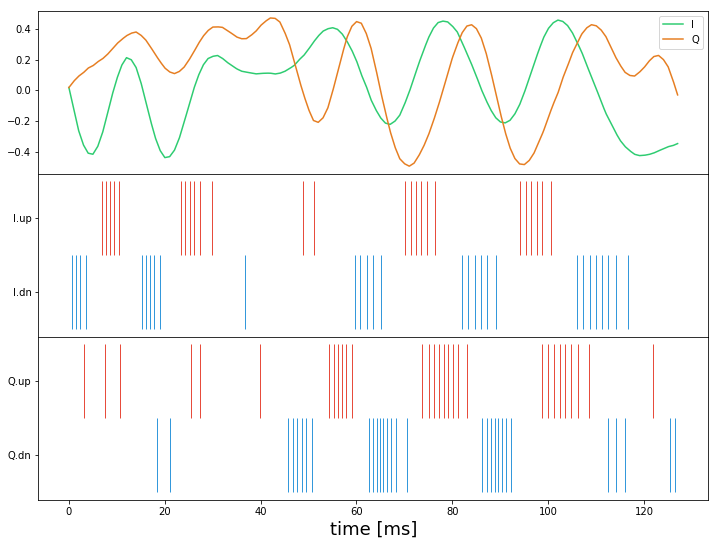

In [4]:
settings = {
    'modulation': 'QPSK',
    'snr': 18,
    'scale': 50,
    'thrup': 0.1,
    'thrdn': 0.1,
    'resampling_factor': 200,
    'stretch_factor': 1000,
    'stop_after': 10000,
    'stop_neuron': 4
}
dataset, _ = load_dataset('./data/radioML/RML2016.10a_dict.pkl', snr=settings['snr'], scale=settings['scale'], normalize=False)
time_sample = np.arange(128)
sample = dataset[(settings['modulation'], settings['snr'])][10]
modulators = [
    AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor']),
    AsynchronousDeltaModulator(settings['thrup'], settings['thrdn'], settings['resampling_factor'])
]
indices, times, time_stim, signal = modulate(modulators[0], modulators[1], time_sample, sample, \
                                             resampling_factor=settings['resampling_factor'], stretch_factor=settings['stretch_factor'])
plot_sample(signal, time_stim*us, indices, times*us, figsize=(12, 9))

In [5]:
bins = np.linspace(np.min(time_stim), np.max(time_stim), num=int(len(time_sample)/10)+1)

In [6]:
stop = round(bins[-1], ndigits=0)+settings['stop_after']
indices = np.append(indices, settings['stop_neuron'])
times = np.append(times, stop)*us

In [7]:
bins = bins*us

In [8]:
duration = 2*stop*us

# DPI Neuron and Synapse

We need to adapt the neuron and synapse time constants to the relevant time scales of the input. With an average time length of about 1ms for a baseband symbol, the DPI neuron should be able to generate spikes in half of this time interval.

## Input layer

The 4 spike generators are connected 1-to-1 to 4 input neurons. These neurons then project the input to 4 different subsets of reservoir neurons. The input neurons should have an integration time shorter than the average baseband symbol time length, in order to produce enough spike per symbol.

## Reservoir layer

The DPI neurons and synapsis in the reservoir layer should produce non-linear dynamics and thus have rather heterogenous properties. We therefore initialize them randomly by drawing from a uniform distribution.

In [9]:
import joblib

In [10]:
params = {
    'wGen': 500,
    'wInp': 500,
    'pIR': 0.1,
    'pInh': 0.2,
    'AoC': [0.3, 0.2, 0.5, 0.1],
    'DoC': 2,
    'loc_wResE': 50,
    'scale_wResE': 10,
    'loc_wResI': -70,
    'scale_wResI': 20,
    'Ninp': 4,
    'N': 800,
    'Ngx': 10,
    'Ngy': 10,
    'Ngz': 8,
}

In [ ]:
with open("./connectivity-schliebs.joblib", "rb") as fo:
    connectivity = joblib.load(fo)

In [12]:
input_neurons_Iup = connectivity['inp_res']['j'][connectivity['inp_res']['i']==0]
input_neurons_Idn = connectivity['inp_res']['j'][connectivity['inp_res']['i']==1]
input_neurons_Qup = connectivity['inp_res']['j'][connectivity['inp_res']['i']==2]
input_neurons_Qdn = connectivity['inp_res']['j'][connectivity['inp_res']['i']==3]
print("Input neurons:")
print("\t - I.up: {}".format(input_neurons_Iup))
print("\t - I.dn: {}".format(input_neurons_Idn))
print("\t - Q.up: {}".format(input_neurons_Qup))
print("\t - Q.dn: {}".format(input_neurons_Qdn))

Input neurons:
	 - I.up: [ 16  19  34  35  37  49  69  80  84  85  90  91  95 106 137 140 142 145
 158 162 191 197 203 210 211 213 220 226 241 248 250 255 259 269 277 285
 354 368 376 381 390 395 414 429 437 446 447 449 459 464 471 479 484 498
 503 517 538 554 558 605 610 614 616 617 622 624 626 648 651 655 660 674
 685 687 689 698 705 710 721 756 758 773 775]
	 - I.dn: [ 20  23  29  36  46  49  51  63  69  89 110 124 126 145 151 154 158 167
 173 179 201 205 211 216 225 250 260 267 268 297 341 346 350 358 361 363
 377 388 416 425 427 450 452 474 492 514 522 527 528 538 543 563 568 584
 596 610 617 618 621 629 638 657 668 672 692 699 720 721 733 741 748 759
 769 770 785 786 794 797]
	 - Q.up: [  3   6  13  37  50  58  82  88  92  98 116 131 133 136 140 147 174 181
 188 205 214 247 252 253 261 275 282 293 294 298 306 309 317 323 396 405
 425 433 447 462 463 474 476 484 492 498 513 518 524 531 534 535 564 573
 584 593 595 599 606 611 613 627 637 650 667 687 691 696 697 703 713 754
 755 75

In [19]:
num_syn = len(connectivity['res_res']['w'])
params['currents'] = {
    'gInp': {
        'Iahp': 0.5*pA,
        'Itau': getTauCurrent(5*ms),
        'Ispkthr': 0.2*nA
    },
    'gRes': {
        'Iahp': 0.5*pA,
        'Itauahp': getAhpTauCurrent(50*ms),
        'Itau': getTauCurrent(20*ms),
        'Ispkthr': 0.2*nA
    },
    'sInpRes': {
        'Ie_tau': getTauCurrent(7*ms)
    },
    'sResRes': {
        'Ie_tau': getTauCurrent(7*ms),
        'Ii_tau': getTauCurrent(2*ms) 
    }
}
params['mismatch'] = {
    'gRes': {
        'Itau': 0.1,
        'Ispkthr': 0.2
    },
    'sResRes': {
        'Ie_tau': 0.1,
        'Ii_tau': 0.1,
    }
}

In [20]:
components = {'generator': None, 'layers': {}, 'synapses': {}, 'monitors': {}}
components = setup_generator(components)
components = setup_input_layer(components, connectivity, params['mismatch'], params['Ninp'], params['currents'], params['wGen'])
components = setup_reservoir_layer(components, connectivity, params['mismatch'], params['N'], params['currents'], params['wInp'])

In [21]:
network = init_network(components, indices, times)
defaultclock.dt = 50*us
network.run(duration)

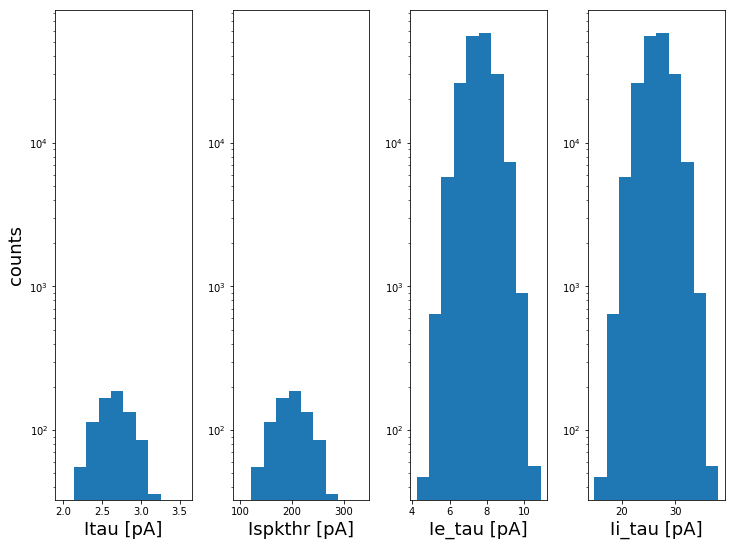

In [22]:
plot_currents_distributions(network, figsize=(12, 9))

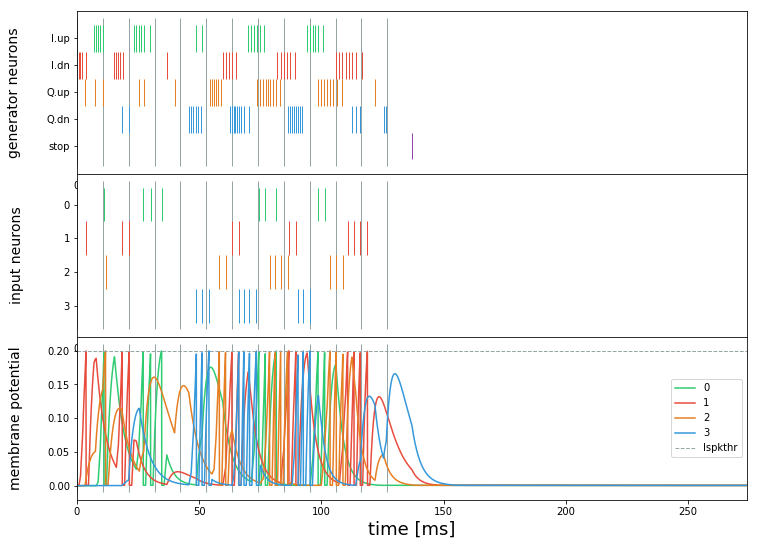

In [23]:
plot_input_layer_with_membrane_potential(indices, times, network, duration, bins=bins, figsize=(12, 9))

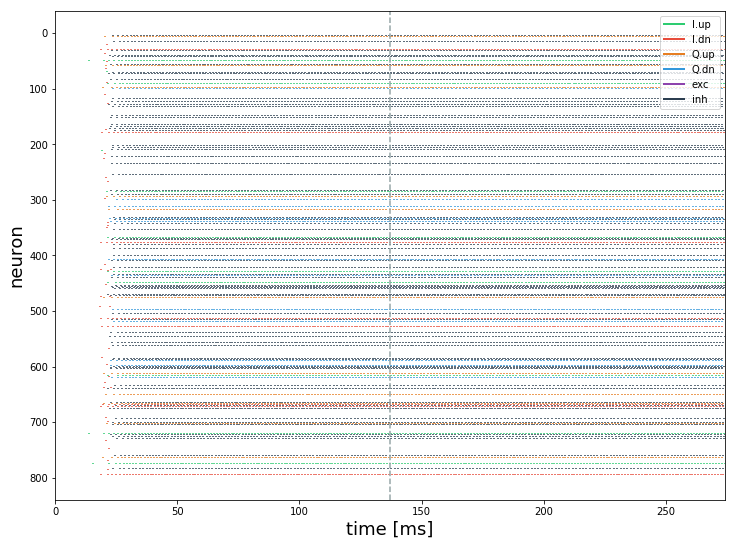

In [25]:
plot_reservoir_raster(connectivity, params, network, times, duration, figsize=(12, 9))
plt.savefig("images/chaotic-runoff.pdf", bbox_inches="tight")